In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt
from trade_obj import *

from simple_backtester import backTester
ticker = 'GLD'
df = pd.read_csv('datasets/daily_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')



In [5]:
df['20_up_bound'] = df['high'].shift(1).rolling(20).max()
df['20_low_bound'] = df['low'].shift(1).rolling(20).min()
df['10_up_bound'] = df['high'].shift(1).rolling(10).max()
df['10_low_bound'] = df['low'].shift(1).rolling(10).min()


df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


# df1 = df[-500:].copy()
# df1['20_up_bound'].plot()
# df1['20_low_bound'].plot()
# df1['55_up_bound'].plot()
# df1['55_low_bound'].plot()
# df1['close'].plot()
# plt.show()

# df1['ATR'].plot()
# plt.show()

In [6]:
bt = backTester()
df = df.dropna()
# df = df[-1000:]
bt.set_asset(df)

upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()

stop_loss_arr = []
stop_loss = np.nan

tl = tradeList()
last_trade_win = False
open_trade = None
open_trade55 = None


for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    # risk_unit = int(bt.portfolio_value * 0.02 / (3 * n))
    risk_unit = bt.cash // bt.high[i]
    

    # no open trades
    if open_trade == None:
        # breakout from 20 day high
        if bt.high[i] > upbound20[i]:
            # print(f'--- index {i}, date: {bt.date[i]} ---')
            # print(f'high: {bt.high[i]} > long breakout: {upbound20[i]}')
            long_entry_price = upbound20[i]
            # calculate stop_loss
            stop_loss = long_entry_price - 3 * n
            
            # if not last_trade_win:
            if True:
                
                # order price at breakout
                order_price = long_entry_price
                # order 1 unit
                order_quantity = risk_unit
                
                # open trade on record
                open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
                # print(f'entry price: {order_price}, quantity: {order_quantity}')

            else:
                long_entry_price = upbound20[i]
                # print('last trade was profitable: fake trade')
                open_trade = fakeTrade(1)

            

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity > 0:
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - 3 * n)
            # print(f'stop_loss {stop_loss}')
            # print(f'lowbound10 {lowbound10[i]}')
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound10[i])
            

            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:
                if open_trade.type == 'fake':
                    # close fake trade
                    last_trade_win = True if stop_loss > long_entry_price else False
                else:
                    # print(f'--- index {i}, date: {bt.date[i]} ---')
                    # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                    # exit price at stoploss
                    order_price = stop_loss
                    order_quantity = -open_trade.quantity
                        
                    open_trade.close(bt.date[i], order_price)
                    tl.append(open_trade)
                    if order_price < long_entry_price:
                        last_trade_win = -1
                    else:
                        last_trade_win = 1
                    entry_exit = order_price
                
                open_trade = None
                stop_loss = np.nan
    
    


        
    stop_loss_arr.append(stop_loss)

    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            

df['stop_loss'] = stop_loss_arr


df['entry_price'] = np.nan
df['exit_price'] = np.nan
df['entry_price'] = np.nan
df['exit_price'] = np.nan
for t in tl.list:

    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



end


In [7]:
print(len(bt.date))

4631


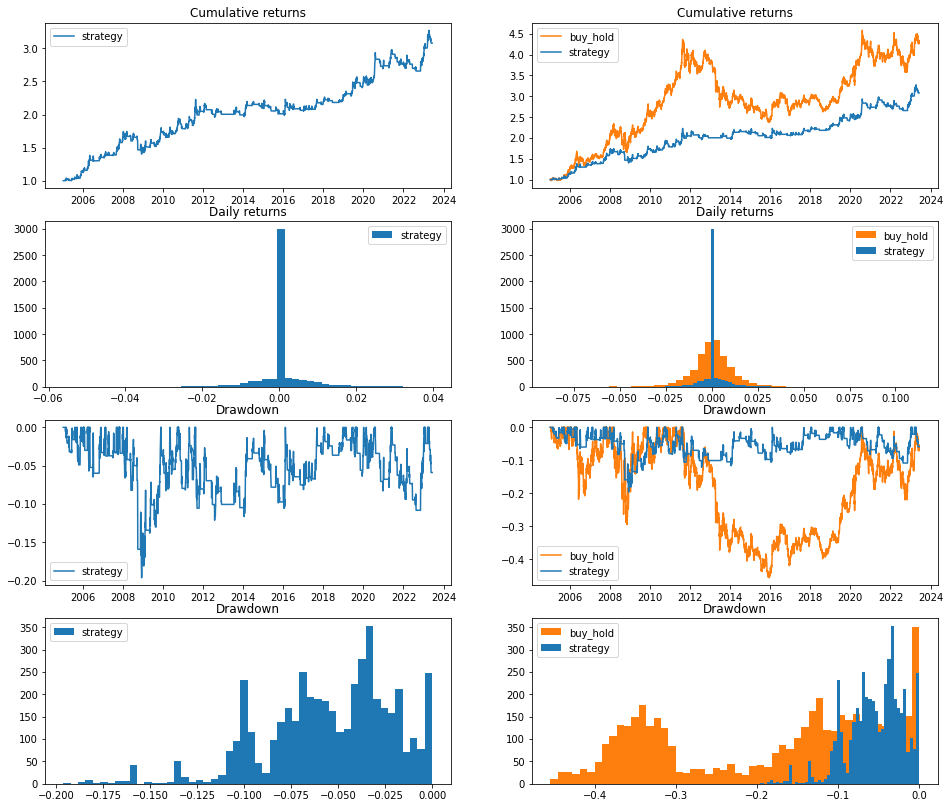

In [8]:
bt.analyse()
bt.plot_graphs()

In [9]:
# bt.records['cash'].plot()

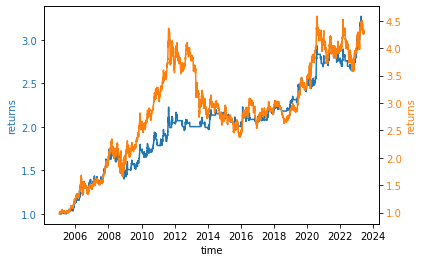

In [10]:

fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [11]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.06306516300387788
buy_hold annual return:     0.08269865064606252
Annualised vol:             0.10021561427844505
buy_hold annual vol:        0.17828519282578964
Sharpe ratio:               0.6292947806382133
buy_hold Sharpe ratio:      0.46385596770715015


In [12]:
bt.records.to_csv(ticker + '_rec.csv')

In [13]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 62,
 'num_loss': 53,
 'win_rate': 0.5391304347826087,
 'profit_total': 2080247.1380943302,
 'profit_mean': 18089.10554864635,
 'returns_mean': 0.010708529060701164,
 'returns_std': 0.04068583508120697,
 'time_in_trade_mean': 21.321739130434782,
 'time_in_trade_std': 15.306544768116927,
 'capital_at_risk_mean': 1985310.4014981808,
 'win_returns_mean': 0.038033086113232396,
 'win_returns_std': 0.03548132448333081,
 'win_profit_mean': 71278.88114048129,
 'win_time_in_trade_mean': 29.85483870967742,
 'win_time_in_trade_std': 15.47483072731759,
 'loss_returns_mean': -0.021256047113958013,
 'loss_returns_std': 0.014852475619793548,
 'loss_profit_mean': -44132.89608708509,
 'loss_time_in_trade_mean': 11.339622641509434,
 'loss_time_in_trade_std': 6.659127328557326}

In [14]:
# tl.plot_graphs()

In [15]:
# def plot_candle(df, show=False):
#     #define width of candlestick elements
#     width = .4
#     width2 = .05

#     #define up and down t.df
#     up = df[df.close>=df.open].copy()
#     down = df[df.close<df.open].copy()

#     #define colors to use
#     col1 = 'green'
#     col2 = 'red'

#     #plot up t.df
#     plt.bar(up.index,up.close-up.open,width,bottom=up.open,color=col1)
#     plt.bar(up.index,up.high-up.close,width2,bottom=up.close,color=col1)
#     plt.bar(up.index,up.low-up.open,width2,bottom=up.open,color=col1)

#     #plot down t.df
#     plt.bar(down.index,down.close-down.open,width,bottom=down.open,color=col2)
#     plt.bar(down.index,down.high-down.open,width2,bottom=down.open,color=col2)
#     plt.bar(down.index,down.low-down.close,width2,bottom=down.close,color=col2)

#     #rotate x-axis tick labels
#     plt.xticks(rotation=45, ha='right')

#     if show:
#         #display candlestick chart
#         plt.show()


# for i in range(len(tl.list)):
#     t = tl.list[i]

#     print(f'trade {i}')
#     print(f'entry: {t.entry_price}')
#     print(f'cost_basis: {t.cost_basis}')
#     print(f'exit: {t.exit_price}')
#     print(f'returns: {t.returns}')
    
    
#     plot_candle(t.df)
#     print(len(t.df))
    
    
#     plt.plot(t.df['stop_loss'], color='C1')
#     plt.scatter(t.df.index, t.df['entry_price'], marker='^', color='black')
#     plt.scatter(t.df.index, t.df['exit_price'], marker='v', color='black')
#     plt.show()



In [16]:
# import datetime as dt
# mask = (df.index >= pd.to_datetime(dt.date(2008, 1, 1))) & (df.index <= pd.to_datetime(dt.date(2009, 1, 1)))
# df1 = df.loc[mask]
    
# plt.figure(figsize=(15,10)) 
# plot_candle(df1)

# plt.plot(df1['stop_loss'], color='C1')
# plt.scatter(df1.index, df1['entry_price'], marker='^', color='black')
# plt.scatter(df1.index, df1['exit_price'], marker='^', color='black')
# plt.show()

<AxesSubplot:>

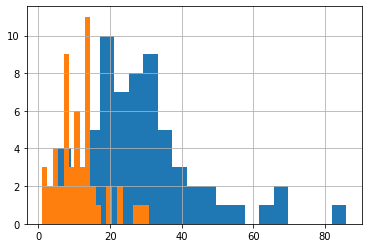

In [17]:
tl.win_records['time_in_trade'].hist(bins=20)
tl.loss_records['time_in_trade'].hist(bins=20)

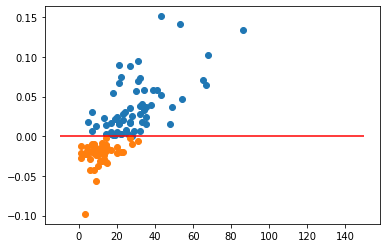

In [18]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'])
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')